# Imports
In this section we import the necessary libraries for the model and declare our constant variables.

In [98]:
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = (48, 48)
DATA_PATHS = {'train': "train", 'test': "test"}

# Data Pre-processing
The data for this model can be found [here](https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset/data). In this section we preprocess our images for training and testing. Using the `image_dataset_from_directory`, images are automatically loaded from structured directories. Once all images are loaded, they are resized to IMAGE_SIZE (48px by 48px), converted to grayscale, and batched. The `label_mode='categorical'` parameter converts labels to one-hot encoded vectors for multi-class classification. Pixel values are then normalized to [0,1] using a rescaling layer. The `prefetch(tf.data.AUTOTUNE)` method optimizes data loading by preparing batches in the background during training.

In [99]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATHS['train'],
    image_size=IMAGE_SIZE,
    color_mode='grayscale',
    batch_size=32,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_PATHS['test'],
    image_size=IMAGE_SIZE,
    color_mode='grayscale',
    batch_size=64,
    label_mode='categorical'
)

normalization_layer = tf.keras.layers.Rescaling(1/255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


# Data fitting
Once our data has been pre-processed we begin creating our convolutional neural network (CNN). We begin with feature extraction using `Conv2D` layers (64 and 128 filters) to detect hierarchical patterns in our images. We also use `ReLU` activation to introduce non-linearity. After each convolution BatchNormalization  is used to accelerate training by stabilizing layer outputs. MaxPooling is also used to downsample spatial dimensions to reduce computation, and Dropout to randomly deactivates 25% of neurons to help prevent overfitting. The extracted features are then flattened into a 1D vector and passed to dense layers for classification: a 128-unit ReLU layer processes high-level features, while a final 3-unit softmax layer outputs class probabilities. Once this is done the model is compiled with the `Adam` optimizer to allow for an adaptive learning rate. The `categorical_crossentropy` loss is used for one-hot encoded labels). Finally, accuracy is used as the primary metric. Training then runs for 10 epochs, using `train_ds` for training and `test_ds` for testing, adjusting weights to map input images to their correct labels while monitoring generalization performance.

In [100]:
model = models.Sequential([
    layers.Conv2D(64, (3,3), activation='relu', input_shape=(*IMAGE_SIZE, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # Must match number of classes in your data
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=test_ds,  # Use separate test set for validation
    epochs=10
)

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,714,179 (6.54 MB)

 Trainable params: 1,713,795 (6.54 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.6999 - loss: 3.0363 - val_accuracy: 0.3333 - val_loss: 7.7434
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9972 - loss: 0.0089 - val_accuracy: 0.3333 - val_loss: 16.0883
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.3333 - val_loss: 20.1415
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 1.0000 - loss: 6.5139e-04 - val_accuracy: 0.3333 - val_loss: 20.3352
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 1.0000 - loss: 4.2345e-04 - val_accuracy: 0.3602 - val_loss: 17.9535
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 1.0000 - loss: 3.4063e-04 - val_accuracy: 0.3683 - val_loss: 13.0473
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 1.0000 - loss: 3.1682e-04 - val_accuracy: 0.4839 - val_loss: 7.7179
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 1.0000 - loss: 3.9935e-04 -

# Predictions
First, `model.evaluate(test_ds)` calculates the models test loss and accuracy. The model then generates predictions for all test samples, producing probability distributions over classes, which are converted to discrete labels using `np.argmax` for comparison. The true labels are aggregated from the test dataset batches to align with predictions. Finally, a 5×5 grid of test images is plotted, with each subplot displaying a grayscale image, its true label, and the predicted label.

6/6 - 0s - 20ms/step - accuracy: 0.7446 - loss: 1.6278

Test accuracy: 0.7446
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


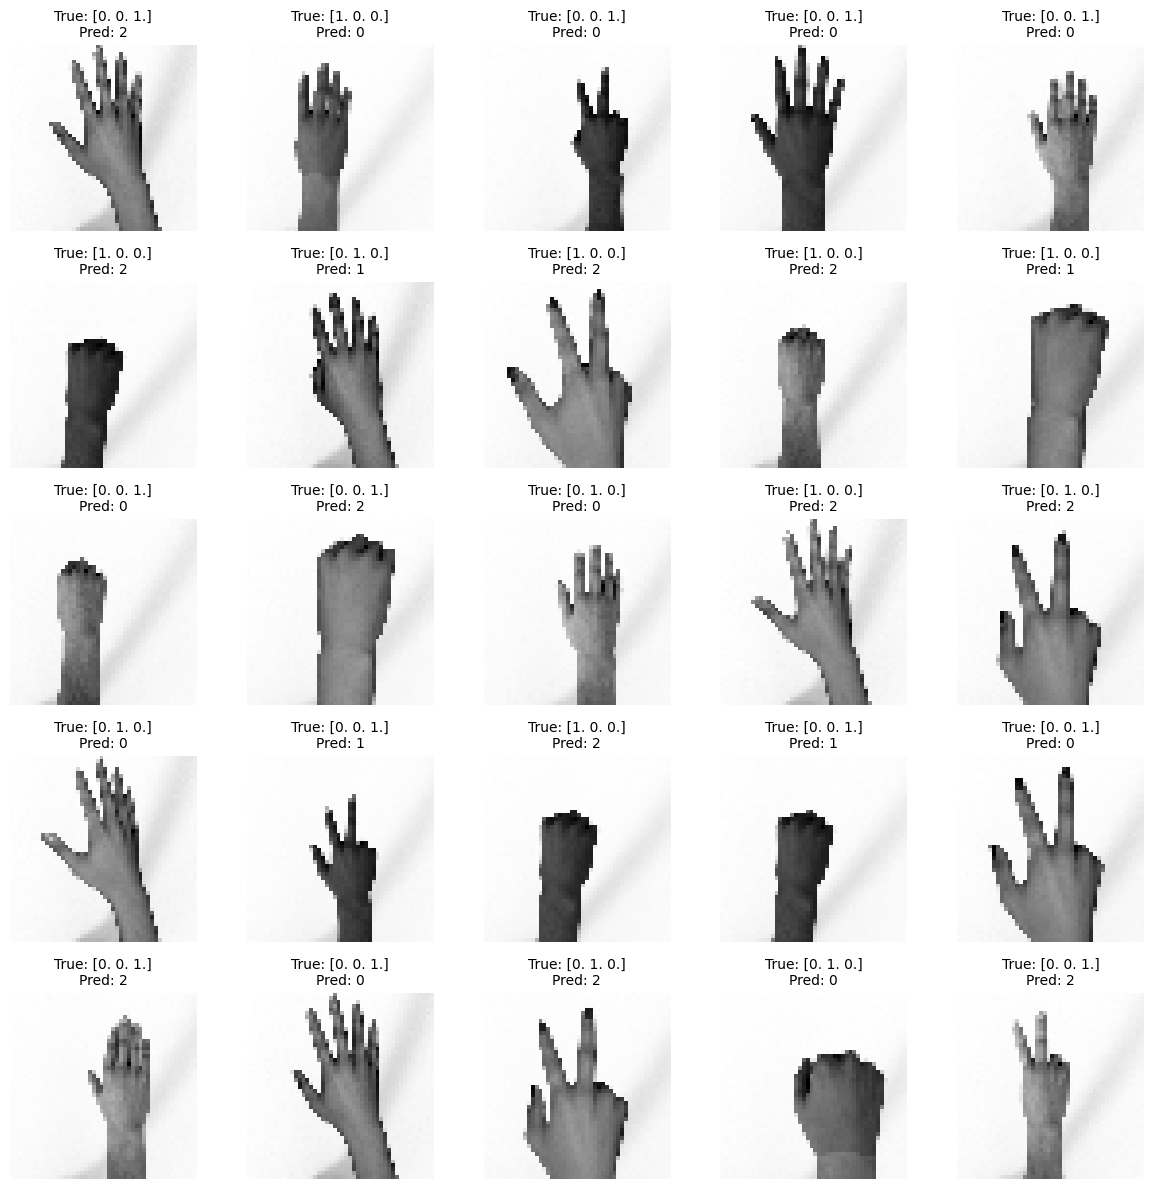

In [101]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f'\nTest accuracy: {test_acc:.4f}')

predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.concatenate([y for x, y in test_ds], axis=0)

plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)

    for images, _ in test_ds.take(1):
        img = images[i].numpy().squeeze()

    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()